### 05 ResNet

In this notebook we will be implementing the [ResNet](https://arxiv.org/abs/1512.03385)(Residual Network) which is much like what we did in the last notebook with the VGG. ResNet was designed dor the ImageNet challange which won in 2015.

ResNet, like VGG, also has multiple configurations which specify the number of layers and the sizes of those layers. Each layer is made out of blocks, which are made up of convolutional layers, batch normalization layers and residual connections (also called skip connections or shortcut connections). Confusingly, ResNets use the term "layer" to refer to both a set of blocks, e.g. "layer 1 has two blocks", and also the total number of layers within the entire ResNet, e.g. "ResNet18 has 18 layers".

A residual connection is simply a direct connection between the input of a block and the output of a block. Sometimes the residual connection has layers in it, but most of the time it does not. Below is an example block with an identity residual connection, i.e. no layers in the residual path.

![img](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/assets/resnet-skip.png)

> The different ResNet configurations are known by the total number of layers within them - ResNet18, ResNet34, ResNet50, ResNet101 and ResNet152

![img](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/assets/resnet-table.png)


From the table above, we can see that for ResNet18 and ResNet34 that the first block contains two 3x3 convolutional layers with 64 filters, and that ResNet18 has two of these blocks in the first layer, whilst Resnet34 has three. ResNet50, ResNet101 and ResNet152 blocks have a different structure than those in ResNet18 and ResNet34, and these blocks are called bottleneck blocks. Bottleneck blocks reduce the number of number of channels within the input before expanding them back out again. Below shows a standard BasicBlock (left) - used by ResNet18 and ResNet34 - and the Bottleneck block used by ResNet50, ResNet101 and ResNet152.

![img](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/assets/resnet-blocks.png)

Why do ResNets work? The key is in the residual connections. Training incredibly deep neural networks is difficult due to the gradient signal either exploding (becoming very large) or vanishing (becoming very small) as it gets backpropagated through many layers. Residual connections allow the model to learn how to "skip" layers - by setting all their weights to zero and only rely on the residual connection. Thus, in theory, if your ResNet152 model can actually learn the desired function between input and output by only using the first 52 layers the remaining 100 layers should set their weights to zero and the output of the 52nd layer will simply pass through the residual connections unhindered. This also allows for the gradient signal to also backpropagate through those 100 layers unhindered too. This outcome could also also be achieved in a network without residual connections, the "skipped" layers would learn to set their weights to one, however adding the residual connection is more explicit and is easier for the model to learn to use these residual connections.

The image below shows a comparison between VGG-19, a convolutional neural network architecture without residual connections, and one with residual connections - ``ResNet34``.

![img](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/assets/vgg-resnet.png)

In this notebook we'll also be showing how to use torchvision to handle datasets that are not part of ``torchvision.datasets``. Specificially we'll be using the 2011 version of the [CUB200](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset. This is a dataset with 200 different species of birds. Each species has around 60 images, which are around ``500x500`` pixels each. Our goal is to correctly determine which species an image belongs to - a 200-dimensional image classification problem.

As this is a relatively small dataset - ~12,000 images compared to CIFAR10's 60,000 images - we'll be using a pre-trained model and then performing transfer learning using **discriminative fine-tuning**.

We'll also be using a ``learning rate scheduler``, a PyTorch wrapper around an optimizer which allows us to dynamically alter its learning rate during training. Specifically, we'll use the one ``cycle learning learning rate scheduler``, also known as ``superconvergnence``, from this [paper](https://arxiv.org/abs/1803.09820) and is commonly used in the [fast.ai](https://course.fast.ai/) course.


### Data Processing
* ``lr_scheduler`` for using the one cycle learning rate scheduler
* ``namedtuple`` for handling ResNet configurations
* ``os`` and ``shutil`` for handling custom datasets.

In [96]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from torchvision import models

import random, time, os, copy, shutil
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

from sklearn import decomposition, manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from prettytable import PrettyTable

torch.__version__

'1.9.0+cu102'

### Seeds

In [97]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

We'll be using our own dataset instead of using one provided by `torchvision.datasets`.

Instead, we'll download the dataset from Kaggle using the kaggle-api which needs to be installed with:

```
pip install kaggle
```
First, we need to have a Kaggle account in order to generate an **API key**. Once we're logged on to Kaggle, we need to go to: 

1. https://www.kaggle.com/<username>/account
2. Click Generate New API Token which will download a ``kaggle.json`` file. 
3. Place this at ``~/.kaggle/kaggle.json`` (or, if you're on Windows, at ``C:\Users\<Windows-username>\.kaggle\kaggle.json)``.
4. If we are using Google Colab, an alternative is simply set the environment variables ``KAGGLE_USERNAME`` and ``KAGGLE_KEY`` to their respective values. This is what we do below.

Next, we'll download the dataset from where it is hosted on Kaggle, at: https://www.kaggle.com/veeralakrishna/200-bird-species-with-11788-images. This is done with `!kaggle datasets download <kaggle-url> --unzip`, where the ``<kaggle-url>`` is the dataset URL after the kaggle.com part, which is ``veeralakrishna/`` 200-bird-species-with-11788-images for this dataset.

``datasets.utils`` contains some functionality for downloading and extract data which means we don't have to write it ourselves.

We use the extract_archive function, which extracts a file to a given root folder. We should now have a data/``CUB_200_2011`` folder which contains our entire dataset.


In [99]:
os.environ["KAGGLE_USERNAME"]="YOUR_USERNAME"
os.environ['KAGGLE_KEY'] = "YOUR_KEY"

In [100]:
!pip install kaggle
!kaggle datasets download veeralakrishna/200-bird-species-with-11788-images --unzip
ROOT = 'data'

datasets.utils.extract_archive('CUB_200_2011.tgz', ROOT)

 99% 1.09G/1.11G [00:07<00:00, 156MB/s]
100% 1.11G/1.11G [00:07<00:00, 161MB/s]


'data'

To handle custom datasets, torchvision provides a ``datasets.ImageFolder`` class. 

`datasets.ImageFolder` expects data to be in the following way:

```
root
  - classx
    - x.png
    - x.jpg
  ....

  - classy
    - y.png
    - y.jpg
```

That is, each folder in the root directory is the name of a class, and within each of those folders are the images that correspond to that class. The images in the downloaded dataset are currently in the form of:

```
CUB_200_2011/images/class_a/image_1.jpg
CUB_200_2011/images/class_a/image_2.jpg

CUB_200_2011/images/class_b/image_1.jpg
CUB_200_2011/images/class_b/image_2.jpg

CUB_200_2011/images/class_c/image_1.jpg
CUB_200_2011/images/class_c/image_2.jpg
```
This means we could call ``datasets.ImageFolder(root = '.data/CUB_200_2011/images)`` and it would load all of the data. However, we want to split our data into ``train`` and ``test`` splits. This could be done with ``data.random_split``, which we have used in the past to create our validation sets - but we will show how to manually create a ``train`` and ``test`` folder and store the relevant images in those folders. This way means that we only need to create a ``train/test`` split once and re-use it each time we re-run the notebook.

We first set a ``TRAIN_RATIO`` which will decide what percentage of the images per class are used to make up the training set, with the remainder making up the test set. We create a train and test folder within the ``CUB_200_2011 folder`` - after first deleting them if they already exist. Then, we get a list of all ``classes`` and loop through each class. For each class we get the image names, use the first ``TRAIN_RATIO`` of them for the training set and the remainder for the test set. We then copy - with ``shutil.copyfile`` - each of the images into their respective train or test folder. It is usually better to copy, rather than move, the images to create your custom splits just in case we accidentally mess up somewhere.

After running the below cell we have our training set as:

```
CUB_200_2011/images/train/class_a/image_1.jpg
CUB_200_2011/images/train/class_a/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg
```
and our test set as:
```
CUB_200_2011/images/test/class_a/image_48.jpg
CUB_200_2011/images/test/class_a/image_49.jpg

CUB_200_2011/images/test/class_b/image_48.jpg
CUB_200_2011/images/test/class_b/image_49.jpg

CUB_200_2011/images/test/class_c/image_48.jpg
CUB_200_2011/images/test/class_c/image_49.jpg
```
* This train/test split only needs to be created once and does not need to be created again on subsequent runs.

**Note**: ImageFolder will only load files that have image related extensions, i.e. ``jpg/jpeg/png``, so if there was, for example, a ``.txt`` file in one of the class folders then it would not be loaded with the images. If we wanted more flexibility when deciding which files to load or not - such as not loading ``.png`` images or loading images with an esoteric format - then we could either use the ``is_valid_file ``argument of the ``ImageFolder`` class or use[DatasetFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.DatasetFolder) and provide a list of valid extensions to the extensions argument.

In [101]:
TRAIN_RATIO = 0.8

data_dir = os.path.join(ROOT, 'CUB_200_2011')
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

if os.path.exists(train_dir):
  shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
  shutil.rmtree(test_dir)

print("making train/test dirs...")
os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

print("copying files...")
for c in classes:
  class_dir = os.path.join(images_dir, c)
  images = os.listdir(class_dir)
  n_train = int(len(images) * TRAIN_RATIO)
  train_images = images[:n_train]
  test_images = images[n_train:]
  os.makedirs(os.path.join(train_dir, c), exist_ok = True)
  os.makedirs(os.path.join(test_dir, c), exist_ok = True)
  for image in train_images:
    image_src = os.path.join(class_dir, image)
    image_dst = os.path.join(train_dir, c, image) 
    shutil.copyfile(image_src, image_dst)
  for image in test_images:
    image_src = os.path.join(class_dir, image)
    image_dst = os.path.join(test_dir, c, image) 
    shutil.copyfile(image_src, image_dst)

print("Done!")

making train/test dirs...
copying files...
Done!


Now we've got our train/test splits we can go ahead and calculate the mean and standard deviation (std) of our dataset to normalize it. We're actually going to use a pre-trained model in this notebook so will be using the mean and std desired by the pre-trained data, so we don't actually have to calculate this - however it is left as an example.

Calculating the ``mean`` and ``std`` is slightly different than when using a dataset provided by ``torchvision`` as those datasets have all of the images stored as numpy arrays in the data's data attribute, whilst datasets loaded by ``ImageFolder`` and ``DataFolder`` do not.

First, we load the ``train_data`` from the train folder. **Remember**: the mean and std must only be calculated from the training data. This will load ``PIL`` images by default so we pass the ``ToTensor`` transform which converts all the ``PIL`` images to tensors and scales them from ``0-255`` to ``0-1``.

We then loop through each image and calculate the ``mean`` and ``std`` across the ``height`` and ``width`` dimensions with ``dim = (1,2)``, summing all the means and stds and then finding the average by dividing them by the number of examples, ``len(train_data)``.


In [102]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform= transforms.ToTensor()
)

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
  means += torch.mean(img, dim = (1,2))
  stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4861, 0.4994, 0.4316])
Calculated stds: tensor([0.1821, 0.1810, 0.1930])


Now to actually load our data. As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb) page.

In [103]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
  transforms.Resize(pretrained_size),
  transforms.RandomRotation(5),
  transforms.RandomHorizontalFlip(0.5),
  transforms.RandomCrop(pretrained_size, padding = 10),
  transforms.ToTensor(),
  transforms.Normalize(mean = pretrained_means, 
                      std = pretrained_stds)
])

test_transforms = transforms.Compose([
  transforms.Resize(pretrained_size),
  transforms.CenterCrop(pretrained_size),
  transforms.ToTensor(),
  transforms.Normalize(mean = pretrained_means, 
                    std = pretrained_stds)
])

### Loading our custom data

In [104]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)
test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

Creating a validation data from the train data

In [105]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

Overiding the transforms of the train on the validation set with the test transforms..

In [106]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

### Checking examples

To make sure nothing has messed up we'll print the number of examples in each of the data splits - ensuring they add up to the number of examples indicated on the [CUB200-2011 dataset website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) (11,788).

In [107]:
def tabulate(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = [("training", len(train_data)), 
             ("testing", len(test_data)), 
             ("validation", len(valid_data)),
             ("total", f"{len(valid_data) + len(test_data) + len(train_data):,}")
        ]
tabulate(columns, data_rows, title)

+---------------------+
|  DATASETS EXAMPLES  |
+------------+--------+
| SET        |  TOTAL |
+------------+--------+
| training   |   8472 |
| testing    |   2374 |
| validation |    942 |
| total      | 11,788 |
+------------+--------+


### Creating an iterator

In [108]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE
                                 )
valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE
                                 )
test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE
                                )

### Visualizing images

In [109]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

In [110]:
def plot_images(images, labels, classes, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.axis('off')

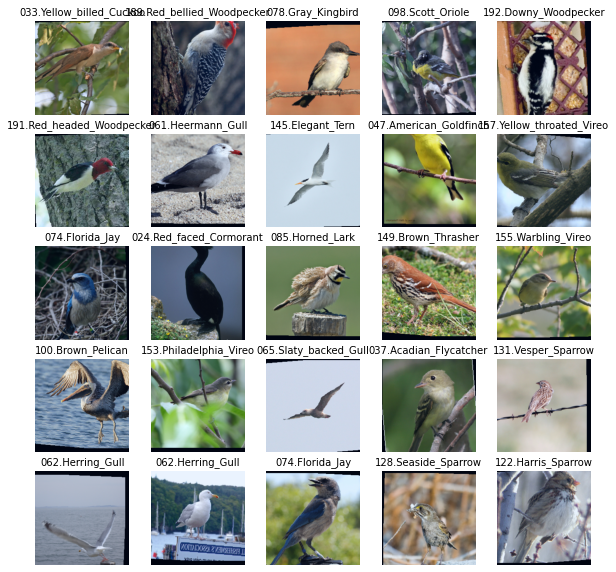

In [111]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

One way to solve the issue with the names of the classes would have been to manually change the names of the folders before we copied them over into the ``train`` and ``test`` folders

Another approach is to directly change the names of each class provided by the dataset's ``.classes``. We'll make a ``format_label`` function which will strip off the number at the start of each class and convert them into title case.

In [112]:
def format_label(label):
  label = label.split('.')[-1]
  label = label.replace('_', ' ')
  label = label.title()
  label = label.replace(' ', '')
  return label

Let's change the class names and re-plot the images with their new class names.

No more overlapping!

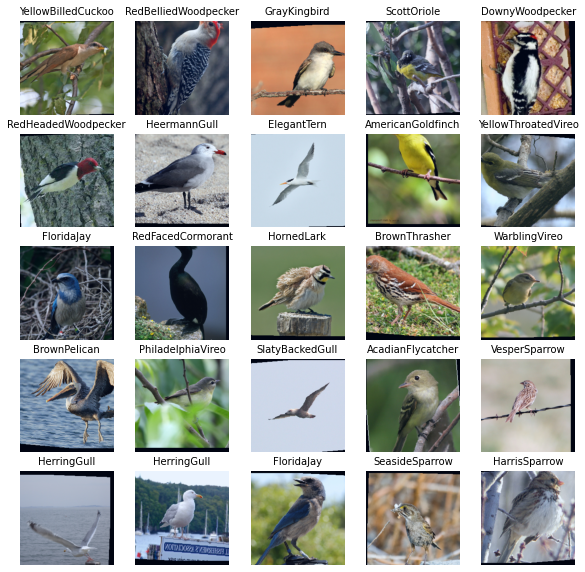

In [113]:
test_data.classes = [format_label(c) for c in test_data.classes]
classes = test_data.classes
plot_images(images, labels, classes)

### Model Definition
Next up, we'll be defining our model. As mentioned previously, we'll be using one of the residual network (ResNet) models. Let's look at the ResNet configuration table again:

![img](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/assets/resnet-table.png)

As we can see, there is a common ``7x7`` convolutional layer and max pooling layer at the start of all ResNet models - these layers also have padding, which is not shown in the table. These are followed by four "layers", each containing a different number of blocks. There are two different blocks used, one for the ResNet18 and ResNet34 - called the ``BasicBlock`` - , and one for the ResNet50, ResNet101 and ResNet152 - called the ``Bottleneck`` block.

Our ``ResNet`` class defines the initial ``7x7`` convolutional layer along with batch normalization, a ``ReLU`` activation function and a downsampling max pooling layer. We then build the four layers from the provided configuration, config, which specifies: the block to use, the number of blocks in the layer, and the number of channels in that layer. For the ``BasicBlock`` the number of channels in a layer is simply the number of filters for both of the convolutional layers within the block. For the ``Bottleneck`` block, the number of channels refers to the number of filters used by the first two convolutional layers - the number of the filters in the final layer is the number of channels multiplied by an expansion factor, which is 4 for the ``Bottleneck`` block (and 1 for the ``BasicBlock``). Also note that the stride of the first layer is one, whilst the stride of the last three layers is two. This stride is only used to change the stride of the first convolutional layer within a block and also in the "downsampling" residual path - we'll explain what downsampling in ResNets means shortly.


``get_resnet_layer`` is used to define the layers from the configuration by creating a nn.Sequential from a list of blocks. The first thing it checks is if the first block in a layer needs to have a downsampling residual path - only the first block within a layer ever needs to have a downsampling residual path. So, what is a downsampling residual path?

![img](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/assets/resnet-skip.png)

Remember that the key concept in the ResNet models is the residual (aka skip/identity) connection. However, if the number of channels within the image is changed in the main connection of the block then it won't have the same number of channels as the image from the residual connection and thus we cannot sum them together. Consider the first block in second layer of ResNet18, the image tensor passed to it will have 64 channels and the output will have 128 channels. Thus, we need to make a residual connection between a 64 channel tensor and a 128 channel tensor. ResNet models solve this using a downsampling connection - technically, it doesn't always downsample the image as sometimes the image height and width stay the same - which increases the number of channels in the image through the residual connection by passing them through a convolutional layer.

Thus, to check if we need to downsample within a block or not, we simply check if the number of channels into the block - ``in_channels`` - is the number of channels out of the block - defined by the ``channels`` argument multipled by the expansion factor of the block. Only the first block in each layer is checked if it needs to downsample or not. After each layer is created, we update ``in_channels ``to be the number of channels of the image when it is output by the layer.

We then follow the four layers with a 1x1 adaptive average pool. This will take the average over the entire height and width of the image separately for each channel. Thus, if the input to the average pool is ``[512, 7, 7]`` (512 channels and a height and width of seven) then the output of the average pool will be ``[512, 1, 1]``. We then pass this average pooled output to a linear layer to make a prediction. We always know how many channels will be in the image after the fourth layer as we continuously update in_channels to be equal to the number of the channels in the image output by each layer.

One thing to note is that the initial convolutional layer has ``bias = False``, which means there is no bias term used by the filters. In fact, every convolutional layer used within every ResNet model always has ``bias = False``. The authors of the ResNet paper argue that the bias terms are unnecessary as every convolutional layer in a ResNet is followed by a batch normalization layer which has a β (beta) term that does the same thing as the bias term in the convolutional layer, a simple addition. See the previous notebook for more details on how batch normalization works.



In [114]:
class ResNet(nn.Module):
  def __init__(self, config, output_dim):
    super(ResNet, self).__init__()
    block, n_blocks, channels = config
    self.in_channels = channels[0]

    assert len(n_blocks) == len(channels) == 4, f"The size of n_block must be equlat to size of chanels must be 4"

    self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

    self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
    self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
    self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
    self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(self.in_channels, output_dim)

  def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    layers = []
    if self.in_channels != block.expansion * channels:
      downsample = True
    else:
      downsample = False
    layers.append(block(self.in_channels, channels, stride, downsample))
    for i in range(1, n_blocks):
      layers.append(block(block.expansion * channels, channels))
    self.in_channels = block.expansion * channels
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    x = self.fc(h)
    return x, h


First up is the ``BasicBlock``.

The ``BasicBlock`` is made of two ``3x3 `` convolutional layers. The first, ``conv1``, has ```` which varies depending on the layer (one in the first layer and two in the other layers), whilst the second, conv2, always has a stride of one. Each of the layers has a padding of one - this means before the filters are applied to the input image we add a single pixel, that is zero in every channel, around the entire image. Each convolutional layer is followed by a ``ReLU`` activation function and batch normalization.

As mentioned in the previous notebook, it makes more sense to use batch normalization after the activation function, rather than before. However, the original ResNet models used batch normalization before the activation, so we do here as well.

When downsampling, we add a convolutional layer with a ``1x1`` filter, and no padding, to the residual path. This also has a variable ``stride`` and is followed by batch normalization. With a stride of one, a ``1x1`` filter does not change the height and width of an image - it simply has ``out_channels`` number of filters, each with a depth of ``in_channels``, i.e. it is increasing the number of channels in an image via a linear projection and not actually downsampling at all. With a stride of two, it reduces the height and width of the image by two as the 1x1 filter only passes over every other pixel - this time it is actually downsampling the image as well as doing the linear projection of the channels.

The ``BasicBlock`` has an ``expansion`` of one as the number of filters used by each of the convolutional layers within a block is the same.

In [115]:
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                            stride = stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                            stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace = True)
    
    if downsample:
      conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                        stride = stride, bias = False)
      bn = nn.BatchNorm2d(out_channels)
      downsample = nn.Sequential(conv, bn)
    else:
       downsample = None
    self.downsample = downsample
        
    def forward(self, x):
      i = x
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      if self.downsample is not None:
          i = self.downsample(i)             
      x += i
      x = self.relu(x)
      

Before we detail the ``Bottleneck`` block, we'll first show how to create the configurations for the ResNet models.

Instead of using a simple list, like we did the for the ``VGG`` model in the previous notebook, we'll use a ``namedtuple``. This will store: the block class, the number of blocks in each layer, and the number of channels in each layer.

In [116]:
ResNetConfig = namedtuple('ResNetConfig', ['block'
, 'n_blocks', 'channels'])

From the ``ResNet`` configuration table, we can create the following configurations for ``ResNet18`` and ``ResNet34``. Notice how the specified channels does not change across configurations, simply the number of blocks used in each layer.

We could then define the ``ResNet18`` and ``ResNet34`` models with:

```
resnet18 = ResNet(resnet18_config, output_dim)
resnet34 = ResNet(resnet34_config, output_dim)
```

In [117]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

The ``Bottleneck`` block, used for ResNet50, ResNet101 and ResNet152.
Instead of two ``3x3`` convolutional layers it has a ``1x1``, ``3x3`` and then another ``1x1`` convolutional layer. Only the ``3x3`` convolutional layer has a variable stride and padding, whilst the ``1x1`` filters have a stride of one and no ``padding``.

The first ``1x1`` filter, ``conv1``, is used to reduce the number of ``channels`` in all layers except the first, where it keeps the number of channels the same, e.g. in first block in of second layer it goes from ``256 ``channels to ``128``. In the case where a ``1x1`` filter reduces the number of channels it can be thought of as a pooling layer across the ``channel`` dimension, but instead of doing a simple maximum or average operation it learns - via its weights - how to most efficiently reduce dimensionality. Reducing the dimensionality is also useful for simply reducing the number of parameters within the model and making it feasible to train.

The second ``1x1`` filter, ``conv3``, is used to increase the number of channels - similar to the convolutional layer in the downsampling path.

The ``Bottleneck`` block has an ``expansion`` of four, which means that the number of channels in the image output a block isn't ``out_channels``, but ``expansion * out_channels``.

The downsampling convolutional layer is similar to that used in the ``BasicBlock``, with the expansion factor taken into account.

In [118]:
class Bottleneck(nn.Module):
  expansion = 4
  def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
    super(Bottleneck, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                            stride = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                            stride = stride, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    
    self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                            stride = 1, bias = False)
    self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
    
    self.relu = nn.ReLU(inplace = True)
    
    if downsample:
      conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                        stride = stride, bias = False)
      bn = nn.BatchNorm2d(self.expansion * out_channels)
      downsample = nn.Sequential(conv, bn)
    else:
      downsample = None
        
    self.downsample = downsample
        
  def forward(self, x):
    i = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    
    x = self.conv3(x)
    x = self.bn3(x)    
    if self.downsample is not None:
        i = self.downsample(i)
    x += i
    x = self.relu(x)
    return x

Below are the configurations for the ``ResNet50``, ``ResNet101`` and ``ResNet152`` models.

Similar to the ``ResNet18`` and ``ResNet34`` models, the ``channels`` do not change between configurations, just the number of blocks in each layer.

We can use the configurations to get the actual models as:
```
resnet50 = ResNet(resnet50_config, output_dim)
resnet101 = ResNet(resnet101_config, output_dim)
resnet152 = ResNet(resnet152_config, output_dim)
```


In [119]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

The ``ResNet`` paper also covers variants specifically for the ``CIFAR10/100`` datasets which we'll very briefly cover here. The code for them is adapted from [this](https://github.com/akamaster/pytorch_resnet_cifar10) repository.

The initial convolutional layer has smaller filter size, lower stride and less padding, and is not followed by a pooling layer. It also only has 3 layers, instead of 4, and has its own type of block.

One requirement is that the number of channels for each layer has to be exactly double that of the previous layer - this is checked by the second ``assert`` statement.

In [120]:
class CIFARResNet(nn.Module):
  def __init__(self, config, output_dim):
    super(CIFARResNet, self).__init__()
            
    block, layers, channels = config
    self.in_channels = channels[0]
        
    assert len(layers) == len(channels) == 3
    assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
    
    self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU(inplace = True)
    
    self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
    self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
    self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
    
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(self.in_channels, output_dim)
        
  def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

    layers = []
    
    if self.in_channels != channels:
        downsample = True
    else:
        downsample = False
    
    layers.append(block(self.in_channels, channels, stride, downsample))
    
    for i in range(1, n_blocks):
        layers.append(block(channels, channels))

    self.in_channels = channels
        
    return nn.Sequential(*layers)
          
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    x = self.fc(h)
  
    return x, h

The ``CIFARBasicBlock`` is similar to the standard BasicBlock, the only difference is in the downsampling residual connection.

The [paper](https://arxiv.org/abs/1512.03385) states that the ResNet models for CIFAR use a downsampling connection that uses "zero padding" and "all shortcuts are parameter free". We achieve this by using an ``Identity`` module, which is initialized with a function and applies that function when called.

For the function, we first slice the input with ``x[:, :, ::2, ::2]``. This removes every other row and column in the image - downsampling it by simply throwing away pixels - whilst keeping the number of channels (depth) the same.

![img](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/assets/resnet-pad.png)

We then double the number of channels with zeros using ``pad``, which adds half the padding on to the front of the depth dimension, and half to the back.

In [121]:
class Identity(nn.Module):
  def __init__(self, f):
    super(Identity, self).__init__()
    self.f = f
    
  def forward(self, x):
    return self.f(x)     

class CIFARBasicBlock(nn.Module):    
  def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
    super(CIFARBasicBlock, self).__init__()
            
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                            stride = stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                            stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    
    self.relu = nn.ReLU(inplace = True)
    
    if downsample:
        identity_fn = lambda x : F.pad(x[:, :, ::2, ::2], 
                                        [0, 0, 0, 0, in_channels // 2, in_channels // 2])
        downsample = Identity(identity_fn)
    else:
        downsample = None
    
    self.downsample = downsample
        
  def forward(self, x):  
    i = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    
    x = self.conv2(x)
    x = self.bn2(x)
    
    if self.downsample is not None:
        i = self.downsample(i)
                            
    x += i
    x = self.relu(x)
    
    return x


Below are the configurations for the ``CIFAR`` ResNet models.

Similar to previous ResNet models, the channels do not change across configurations, just the number of blocks in each layer.

We can use the configurations to get the actual models as:

```
ciafar_resnet_20 = CIFARResNet(cifar_resnet20_config, output_dim)
ciafar_resnet_32 = CIFARResNet(cifar_resnet32_config, output_dim)
ciafar_resnet_44 = CIFARResNet(cifar_resnet44_config, output_dim)
```

In [122]:
cifar_resnet20_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [3, 3, 3],
                                     channels = [16, 32, 64])

cifar_resnet32_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [5, 5, 5],
                                     channels = [16, 32, 64])

cifar_resnet44_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [7, 7, 7],
                                     channels = [16, 32, 64])

cifar_resnet56_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [9, 9, 9],
                                     channels = [16, 32, 64])

cifar_resnet110_config = ResNetConfig(block = CIFARBasicBlock,
                                      n_blocks = [18, 18, 18],
                                      channels = [16, 32, 64])

cifar_resnet1202_config = ResNetConfig(block = CIFARBasicBlock,
                                       n_blocks = [20, 20, 20],
                                       channels = [16, 32, 64])

The images in our dataset are around 500x500 pixels in size, much larger than the 32x32 images used in the CIFAR dataset. This means it's more appropriate for us to use one of the standard ResNet models, instead of the CIFAR versions.

We'll choose ResNet50 as it seems to be the most commonly used ResNet variant.

As we have a relatively small dataset - 12,000 images - with a very small amount of examples per class - 60 images - we'll be using a pre-trained model.

Torchvision provides pre-trained models for all of the standard ResNet variants, but unfortunately not for any of the CIFAR ResNet models.

First, we load the pre-trained ResNet model.

In [123]:
pretrained_model = models.resnet50(pretrained = True)
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We can see that the final linear layer for the classification, fc, has a 1000-dimensional output as it was pre-trained on the ImageNet dataset, which has 1000 classes.

Our dataset, however, only has 200 classes, so we first create a new linear layer with the required dimensions

In [136]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

print(OUTPUT_DIM)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
fc

200


Linear(in_features=2048, out_features=200, bias=True)

Then, we replace the pre-trained model's linear layer with our own, randomly initialized linear layer.

**Note**: even if our dataset had 1000 classes, the same as ImageNet, we would still remove the linear layer and replace it with a randomly initialized one as our classes are not equal to those of ImageNet.

In [137]:
pretrained_model.fc = fc

The pre-trained ResNet model provided by torchvision does not provide an intermediate output, which we'd like to potentially use for analysis. We solve this by initializing our own ResNet50 model and then copying the pre-trained parameters into our model.

We then initialize our ResNet50 model from the configuration...

In [138]:
model = ResNet(resnet50_config, OUTPUT_DIM)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

...then we load the parameters (called state_dict in PyTorch) of the pre-trained model into our model.

This is also a good sanity check to ensure our ResNet model matches those used by torchvision.

In [139]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

We can also see the number of parameters in our model - noticing that ResNet50 only has ~24M parameters compared to VGG11's ~129M. This is mostly due to the lack of high dimensional linear layers which have been replaced by more parameter efficient convolutional layers.

In [140]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
count_params(model)

+-----------------------------------+
|          MODEL PARAMETERS         |
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     | 23,917,832 |
| trainable parameters | 23,917,832 |
+----------------------+------------+


### Freezing the model parameters.

In [145]:
for param in model.parameters():
  param.requires_grad = False

# Put back the fc layer which is trainable
model.fc = fc

def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
count_params(model)

+-----------------------------------+
|          MODEL PARAMETERS         |
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     | 23,917,832 |
| trainable parameters |    409,800 |
+----------------------+------------+


### Training the Model
Next we'll move on to training our model. As in previous notebooks, we'll use the learning rate finder to set a suitable learning rate for our model.

We start by initializing an optimizer with a very low learning rate, defining a loss function ``(criterion)`` and device, and then placing the model and the loss function on to the device.

In [146]:
START_LR = 1e-7

optimizer = torch.optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

The Learning rate Finder class.

In [147]:
class LRFinder:
  def __init__(self, model, optimizer, criterion, device):
    
    self.optimizer = optimizer
    self.model = model
    self.criterion = criterion
    self.device = device
    
    torch.save(model.state_dict(), 'init_params.pt')

  def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                  smooth_f = 0.05, diverge_th = 5):
    
    lrs = []
    losses = []
    best_loss = float('inf')

    lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
    
    iterator = IteratorWrapper(iterator)
    
    for iteration in range(num_iter):

        loss = self._train_batch(iterator)

        #update lr
        lr_scheduler.step()
        
        lrs.append(lr_scheduler.get_lr()[0])

        if iteration > 0:
            loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
            
        if loss < best_loss:
            best_loss = loss

        losses.append(loss)
        
        if loss > diverge_th * best_loss:
            print("Stopping early, the loss has diverged")
            break
                    
    #reset model to initial parameters
    model.load_state_dict(torch.load('init_params.pt'))
                
    return lrs, losses

  def _train_batch(self, iterator):
    
    self.model.train()
    
    self.optimizer.zero_grad()
    
    x, y = iterator.get_batch()
    
    x = x.to(self.device)
    y = y.to(self.device)
    
    y_pred, _ = self.model(x)
            
    loss = self.criterion(y_pred, y)
    
    loss.backward()
    
    self.optimizer.step()
    
    return loss.item()

class ExponentialLR(_LRScheduler):
  def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
    self.end_lr = end_lr
    self.num_iter = num_iter
    super(ExponentialLR, self).__init__(optimizer, last_epoch)

  def get_lr(self):
    curr_iter = self.last_epoch + 1
    r = curr_iter / self.num_iter
    return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
      self.iterator = iterator
      self._iterator = iter(iterator)

    def __next__(self):
      try:
        inputs, labels = next(self._iterator)
      except StopIteration:
        self._iterator = iter(self.iterator)
        inputs, labels, *_ = next(self._iterator)

      return inputs, labels
    def get_batch(self):
        return next(self)

In [148]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)


Stopping early, the loss has diverged


Next, we define a function to plot the results of the range test.

In [149]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
  if skip_end == 0:
    lrs = lrs[skip_start:]
    losses = losses[skip_start:]
  else:
    lrs = lrs[skip_start:-skip_end]
    losses = losses[skip_start:-skip_end]
  
  fig = plt.figure(figsize = (16,8))
  ax = fig.add_subplot(1,1,1)
  ax.plot(lrs, losses)
  ax.set_xscale('log')
  ax.set_xlabel('Learning rate')
  ax.set_ylabel('Loss')
  ax.grid(True, 'both', 'x')
  plt.show()

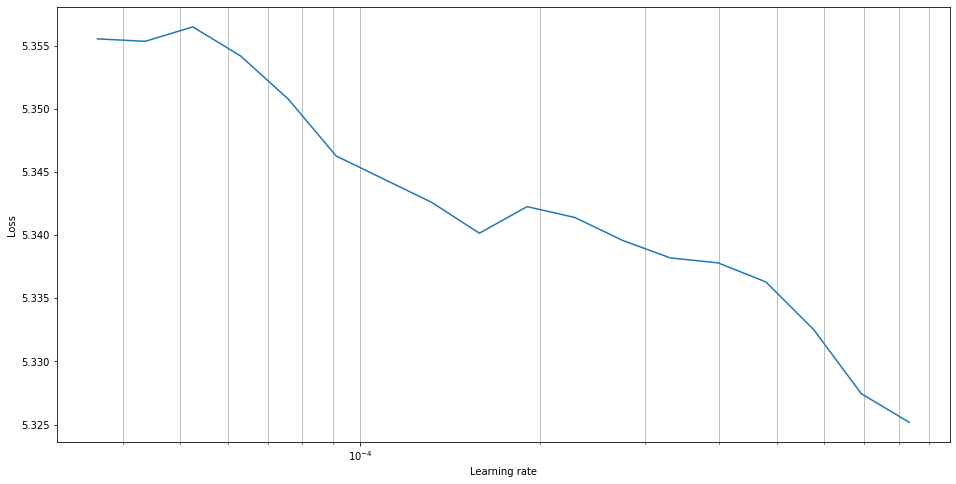

In [150]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

We can then set the learning rates of our model using discriminative fine-tuning - a technique used in transfer learning where later layers in a model have higher learning rates than earlier ones.

We use the learning rate found by the learning rate finder as the maximum learning rate - used in the final layer - whilst the remaining layers have a lower learning rate, gradually decreasing towards the input.

In [153]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]
optimizer = torch.optim.Adam(params, lr = FOUND_LR)

Next up, we set the learning rate scheduler. A learning rate scheduler dynamically alters the learning rate whilst the model is training. We'll be using the one cycle learning rate scheduler, however [many](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) schedulers are available in PyTorch.

The one cycle learning rate scheduler starts with a small initial learning rate which is gradually increased to a maximum value - the value found by our learning rate finder - it then slowly decreases the learning rate to a final value smaller than the initial learning rate. This learning rate is updated after every parameter update step, i.e. after every training batch. For our model, the learning rate for the final ``fc`` layer throughout training will look like:

![img](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/assets/lr-scheduler.png)



As we can see, it starts at slightly less than 1x10−4 before gradually increasing to the maximum value of 1x10−3 at around a third of the way through training, then it begins decreasing to almost zero.

The different parameter groups defined by the optimizer for the discriminative fine-tuning will all have their own learning rate curves, each with different starting and maximum values.

The hypothesis is that the initial stage where the learning rate increases is a "warm-up" phase is used to get the model into a generally good area of the loss landscape. The middle of the curve, where the learning rate is at maximum is supposedly good for acting as a regularization method and prevents the model from overfitting or becoming stuck in saddle points. Finally, the "cool-down" phase, where the learning rate decreases, is used to reach small crevices in the loss surface which have a lower loss value.

The one cycle learning rate also cycles the momentum of the optimizer. The momentum is cycled from a maximum value, down to a minimum and then back up to the maximum where it is held constant for the last few steps. The default maximum and minimum values of momentum used by PyTorch's one cycle learning rate scheduler should be sufficient and we will not change them.

To set-up the one cycle learning rate scheduler we need the total number of steps that will occur during training. We simply get this by multiplying the number of epochs with the number of batches in the training iterator, i.e. number of parameter updates. We get the maximum learning rate for each parameter group and pass this to max_lr. Note: if you only pass a single learning rate and not a list of learning rates then the scheduler will assume this learning rate should be used for all parameters and will not do discriminative fine-tuning.

In [154]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

One other thing we are going to implement is top-k accuracy. Our task is to classify an image into one of 200 classes of bird, however some of these classes look very similar and it is even difficult for a human to correctly label them. So, maybe we should be more lenient when calculating accuracy?

One method of solving this is using top-k accuracy, where the prediction is labelled correct if the correct label is in the top-k predictions, instead of just being the first. Our calculate_topk_accuracy function calculates the top-1 accuracy as well as the top-k accuracy, with k=5 by default.

We use .reshape instead of view here as the slices into tensors cause them to become non-contiguous which means .view throws an error. As a rule of thumb, if you are aiming to change the size/shape of sliced tensors then you should probably use .reshape instead of .view.

Note: our value of k should be chosen sensibly. If we had a dataset with 10 classes then a k of 5 isn't really that informative.

In [155]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

Next up is the training function. This is similar to all the previous notebooks, but with the addition of the scheduler and calculating/returning top-k accuracy.

The scheduler is updated by calling scheduler.step(). This should always be called after optimizer.step() or else the first learning rate of the scheduler will be skipped.

Not all schedulers need to be called after each training batch, some are only called after each epoch. In that case, the scheduler does not need to be passed to the train function and can be called in the main training loop.

In [156]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

Helper functins

In [157]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [159]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 25s
	Train Loss: 5.089 | Train Acc @1:   3.52% | Train Acc @5:  11.90%
	Valid Loss: 4.623 | Valid Acc @1:   9.14% | Valid Acc @5:  30.26%
Epoch: 02 | Epoch Time: 2m 24s
	Train Loss: 3.838 | Train Acc @1:  25.41% | Train Acc @5:  52.60%
	Valid Loss: 3.079 | Valid Acc @1:  36.90% | Valid Acc @5:  66.37%
Epoch: 03 | Epoch Time: 2m 25s
	Train Loss: 2.467 | Train Acc @1:  47.27% | Train Acc @5:  76.46%
	Valid Loss: 2.211 | Valid Acc @1:  46.64% | Valid Acc @5:  77.78%
Epoch: 04 | Epoch Time: 2m 24s
	Train Loss: 1.753 | Train Acc @1:  59.63% | Train Acc @5:  86.47%
	Valid Loss: 1.863 | Valid Acc @1:  54.12% | Valid Acc @5:  83.01%
Epoch: 05 | Epoch Time: 2m 25s
	Train Loss: 1.401 | Train Acc @1:  67.41% | Train Acc @5:  90.12%
	Valid Loss: 1.726 | Valid Acc @1:  55.04% | Valid Acc @5:  83.61%
Epoch: 06 | Epoch Time: 2m 26s
	Train Loss: 1.192 | Train Acc @1:  71.77% | Train Acc @5:  93.06%
	Valid Loss: 1.602 | Valid Acc @1:  58.94% | Valid Acc @5:  85.57%
Epoch: 07 

ValueError: ignored

### Evaluating the bset model.

In [160]:
model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 1.450 | Test Acc @1:  61.79% | Test Acc @5:  88.24%


### Model Examimation

Model examination is the same as the one that we had in the previous notebook.

### Conclusion

In this notebook we have leant a lot of things including how to download data from Kaggle.

### Ref

* [bentrevett](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb)